In [ ]:
import os
import re
import glob
import struct
from os import makedirs

import numpy as np
from numpy import asarray
from numpy import zeros
from nltk.stem.porter import *


import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Reshape, Conv2D, MaxPool2D, Dense, Dropout, Flatten, Embedding, Concatenate, Conv1D
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras import regularizers
from keras import backend as K
from keras.models import load_model

import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier

import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the Dataset


In [ ]:
names = ['TweetID', 'Sentiment', 'Tweet']

train = pd.read_csv('/content/drive/MyDrive/twitter dataset/Datasets/combined_csv.csv')

train.head()

,Column1,Column2,Column3
0,2.641840e+17,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,2.634050e+17,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,2.621630e+17,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,2.642490e+17,negative,Iranian general says Israel\u2019s Iron Dome c...
4,2.626820e+17,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...


Data Preprocessing

In [ ]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

def clean_tweets(frame, column_name):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words

  return frame

In [ ]:
train_set = clean_tweets(train, 'Column3')
train_set.head()

,Column1,Column2,Column3,Tweet_Clean_Text
0,2.641840e+17,positive,Gas by my house hit $3.39!!!! I\u2019m going t...,Gas by my house hit I u m going to Chapel Hill...
1,2.634050e+17,negative,Theo Walcott is still shit\u002c watch Rafa an...,Theo Walcott is still shit u c watch Rafa and ...
2,2.621630e+17,negative,its not that I\u2019m a GSP fan\u002c i just h...,its not that I u m a GSP fan u c i just hate N...
3,2.642490e+17,negative,Iranian general says Israel\u2019s Iron Dome c...,Iranian general says Israel u s Iron Dome can ...
4,2.626820e+17,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...,Tehran u c Mon Amour Obama Tried to Establish ...


In [ ]:
train_set["Sentiment_Value"] = train_set["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
label = to_categorical(train_set["Sentiment_Value"], 3)
train_set

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,2.641840e+17,positive,Gas by my house hit $3.39!!!! I\u2019m going t...,Gas by my house hit I u m going to Chapel Hill...,1
1,2.634050e+17,negative,Theo Walcott is still shit\u002c watch Rafa an...,Theo Walcott is still shit u c watch Rafa and ...,2
2,2.621630e+17,negative,its not that I\u2019m a GSP fan\u002c i just h...,its not that I u m a GSP fan u c i just hate N...,2
3,2.642490e+17,negative,Iranian general says Israel\u2019s Iron Dome c...,Iranian general says Israel u s Iron Dome can ...,2
4,2.626820e+17,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...,Tehran u c Mon Amour Obama Tried to Establish ...,0
...,...,...,...,...,...
49710,6.820000e+17,neutral,@ShaquilleHoNeal from what I think you're aski...,from what I think you re asking in no order F...,0
49711,6.820000e+17,positive,"Iran ranks 1st in liver surgeries, Allah bless...",Iran ranks st in liver surgeries Allah bless t...,1
49712,6.820000e+17,neutral,Hours before he arrived in Saudi Arabia on Tue...,Hours before he arrived in Saudi Arabia on Tue...,0
49713,6.820000e+17,negative,@VanityFair Alex Kim Kardashian worth how to ...,Alex Kim Kardashian worth how to love Kim Kar...,2


In [ ]:
y_labels = train_set['Sentiment_Value']
y_labels.shape

(49715,)

In [ ]:
train['l'] = train_set['Tweet_Clean_Text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(train.l.mean()))
print("max length of sentence: " + str(train.l.max()))
print("std dev length of sentence: " + str(train.l.std()))

mean length of sentence: 20.210278587951322
max length of sentence: 47.0
std dev length of sentence: 5.2648519182168725


In [ ]:
sequence_length = 47 #using the maximum length 

In [ ]:
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(train_set['Tweet_Clean_Text'].values)

X = tokenizer.texts_to_sequences(train_set['Tweet_Clean_Text'].values)
X = pad_sequences(X, sequence_length)
x_train = X

print("training size " + str(len(x_train)))

voc_size = len(tokenizer.word_index) + 1
print("Vocab size: ", voc_size)
print("Input shape: ", x_train.shape)
print("Y_shape: " , y_labels.shape)

training size 49715
Vocab size:  42660
Input shape:  (49715, 47)
Y_shape:  (49715,)


Spliting the dataset

In [ ]:
X_train, X_dev, Y_train, Y_dev = train_test_split(x_train, y_labels, test_size=0.15, shuffle=True, random_state=10)

GloVe Embedding

In [ ]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/GloVe /glove.twitter.27B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((voc_size, embedding_dim))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

METRICS

In [ ]:
import seaborn as sns
from sklearn import metrics

THRESHOLD = 0.35

class EpochMetricsCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = []
        self.precisions = []
        self.recalls = []
        
    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(self.validation_data[0])
        predictions = (predictions > THRESHOLD).astype(int)
        predictions = np.asarray(predictions)
        targets = self.validation_data[1]
        f1 = metrics.f1_score(targets, predictions)
        precision = metrics.precision_score(targets, predictions)
        recall = metrics.recall_score(targets, predictions)

        print(" - F1 score: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}"
              .format(f1, precision, recall))
        self.f1s.append(f1)
        self.precisions.append(precision)
        self.recalls.append(recall)
        return
    
def display_model_history(history):
    data = pd.DataFrame(data={'Train': history.history['loss'], 'Test': history.history['val_loss']})
    ax = sns.lineplot(data=data, palette="pastel", linewidth=2.5, dashes=False)
    ax.set(xlabel='Epoch', ylabel='Loss', title='Loss')
    plt.show()

def display_model_epoch_metrics(epoch_callback):
    fig, axes = plt.subplots(1, 3, figsize = (15, 5), sharey=False)
    a1, a2, a3 = axes
    
    a1.set_title('F1')
    a1.set(xlabel='Epoch', title='F1')
    sns.lineplot(data=pd.DataFrame(data={'F1': epoch_callback.f1s}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a1, legend=False)

    a2.set_title('Precision')
    a2.set(xlabel='Epoch', title='Precision')
    sns.lineplot(data=pd.DataFrame(data={'Precision': epoch_callback.precisions}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a2, legend=False)

    a3.set_title('Recall')
    a3.set(xlabel='Epoch', title='Recall')
    sns.lineplot(data=pd.DataFrame(data={'Recall': epoch_callback.recalls}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a3, legend=False)

    plt.show()

In [ ]:
Y_train_cat = to_categorical(Y_train, 3)
Y_dev_cat = to_categorical(Y_dev, 3)

In [ ]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
Metrics = [
           keras.metrics.CategoricalAccuracy(name = 'categorical_accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics
]

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 15, 10

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_metrics']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

**Stacked CNN Predictions Ensemble**

In [ ]:
def cnn_1(filter_size):
  model = Sequential()
  model.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model.add(Reshape((sequence_length, embedding_dim, 1)))
  model.add(Conv2D(1024, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(units=352, activation='relu'))
  model.add(Dense(units=3, activation='softmax'))
  model.summary()
  filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_model_1.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  cnn_history = model.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, callbacks=callbacks,verbose=2, shuffle=True)
  plot_metrics(cnn_history)
  return model

In [ ]:
train_predictions = []
test_predictions = []

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
reshape_2 (Reshape)          (None, 47, 200, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 1, 1024)       2253824   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 352)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 3s
8/8 - 0s


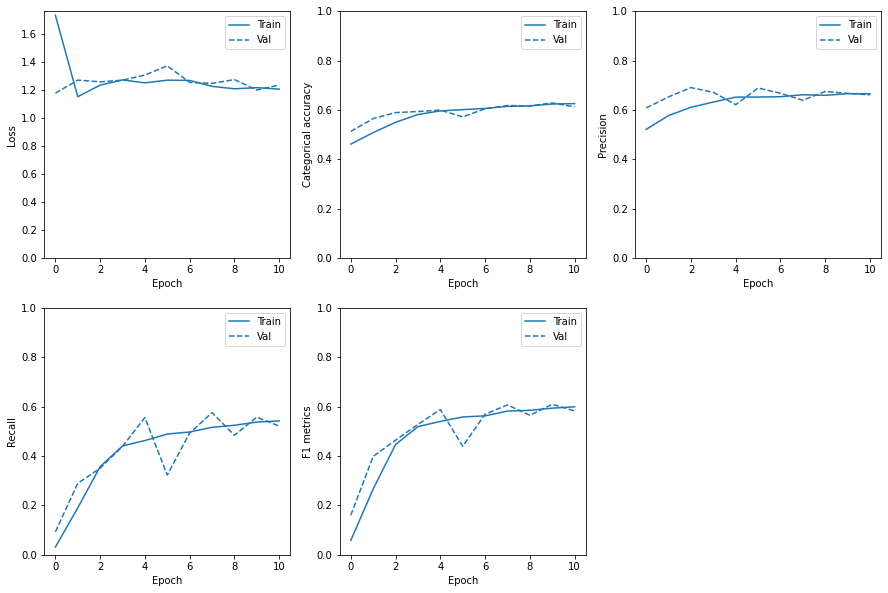

In [ ]:
cnn_1 = cnn_1(11)
train_predictions.append(cnn_1.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions.append(cnn_1.predict_classes([X_dev], batch_size=1024, verbose=2))

In [ ]:
def cnn_2(filter_size):
  model_2 = Sequential()
  model_2.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model_2.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model_2.add(Reshape((sequence_length, embedding_dim, 1)))
  model_2.add(Conv2D(1224, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model_2.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model_2.add(Flatten())
  model_2.add(Dropout(0.5))
  model_2.add(Dense(units=352, activation='relu'))
  model_2.add(Dense(units=3, activation='softmax'))
  model_2.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_model_2.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  cnn_history_2 = model_2.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, callbacks=callbacks,verbose=2, shuffle=True)
  plot_metrics(cnn_history_2)
  return model_2

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
reshape_3 (Reshape)          (None, 47, 200, 1)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 39, 1, 1224)       2204424   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 1224)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1224)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1224)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 352)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 3s
8/8 - 1s


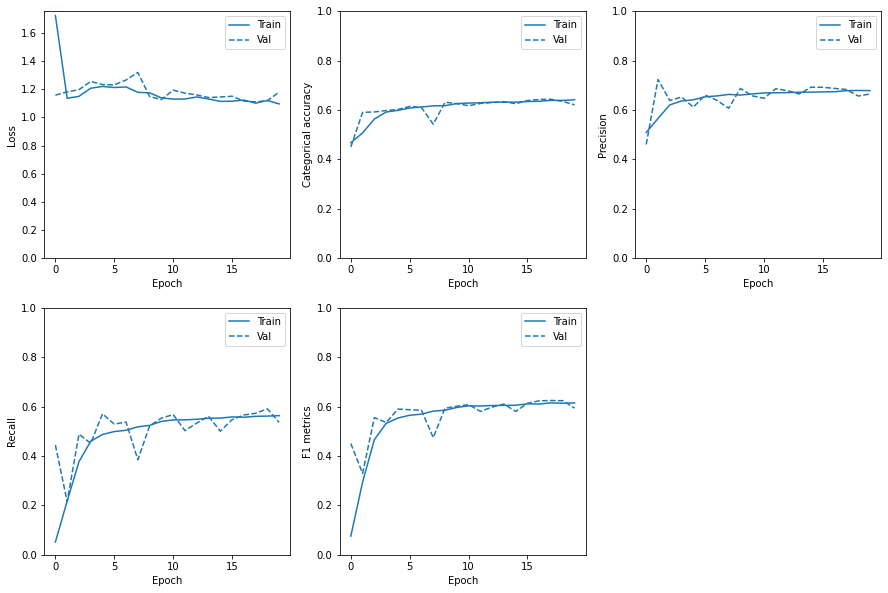

In [ ]:
cnn_2 = cnn_2(9)
train_predictions.append(cnn_2.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions.append(cnn_2.predict_classes([X_dev], batch_size=1024, verbose=2))

In [ ]:
def cnn_3(filter_size):
  model_3 = Sequential()
  model_3.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model_3.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model_3.add(Reshape((sequence_length, embedding_dim, 1)))
  model_3.add(Conv2D(1024, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model_3.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model_3.add(Flatten())
  model_3.add(Dropout(0.5))
  model_3.add(Dense(units=352, activation='relu'))
  model_3.add(Dense(units=3, activation='softmax'))
  model_3.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_model_3.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  cnn_history_3 = model_3.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, callbacks=callbacks,verbose=2, shuffle=True)
  plot_metrics(cnn_history_3)
  return model_3

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
reshape_4 (Reshape)          (None, 47, 200, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 39, 1, 1024)       1844224   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 352)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 3s
8/8 - 0s


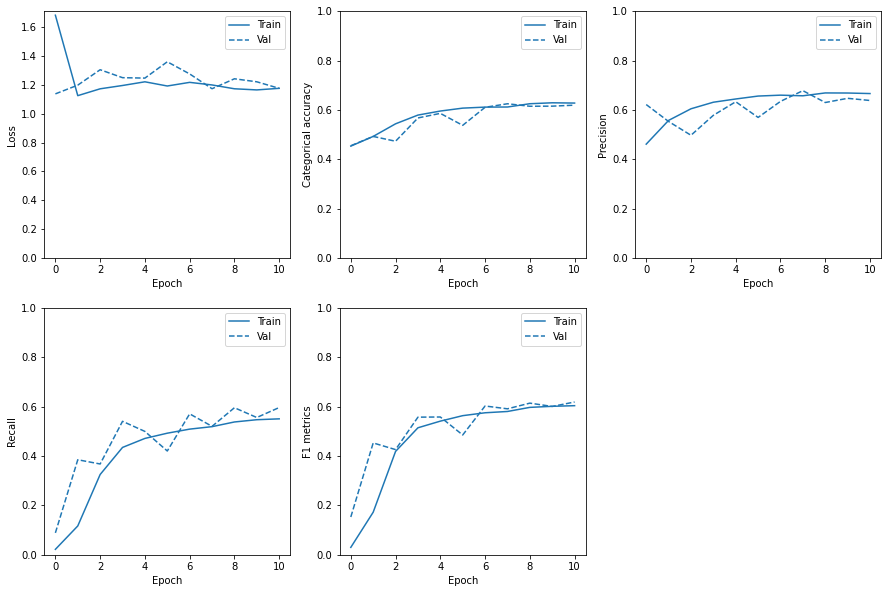

In [ ]:
cnn_3 = cnn_3(9)
train_predictions.append(cnn_3.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions.append(cnn_3.predict_classes([X_dev], batch_size=1024, verbose=2))

In [ ]:
def cnn_4(filter_size):
  model_4 = Sequential()
  model_4.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model_4.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model_4.add(Reshape((sequence_length, embedding_dim, 1)))
  model_4.add(Conv2D(1028, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model_4.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model_4.add(Flatten())
  model_4.add(Dropout(0.5))
  model_4.add(Dense(units=352, activation='relu'))
  model_4.add(Dense(units=3, activation='softmax'))
  model_4.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_model_4.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  cnn_history_4 = model_4.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, callbacks=callbacks,verbose=2, shuffle=True)
  plot_metrics(cnn_history_4)
  return model_4

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
reshape_5 (Reshape)          (None, 47, 200, 1)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 43, 1, 1028)       1029028   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 1028)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1028)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1028)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 352)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 2s
8/8 - 0s


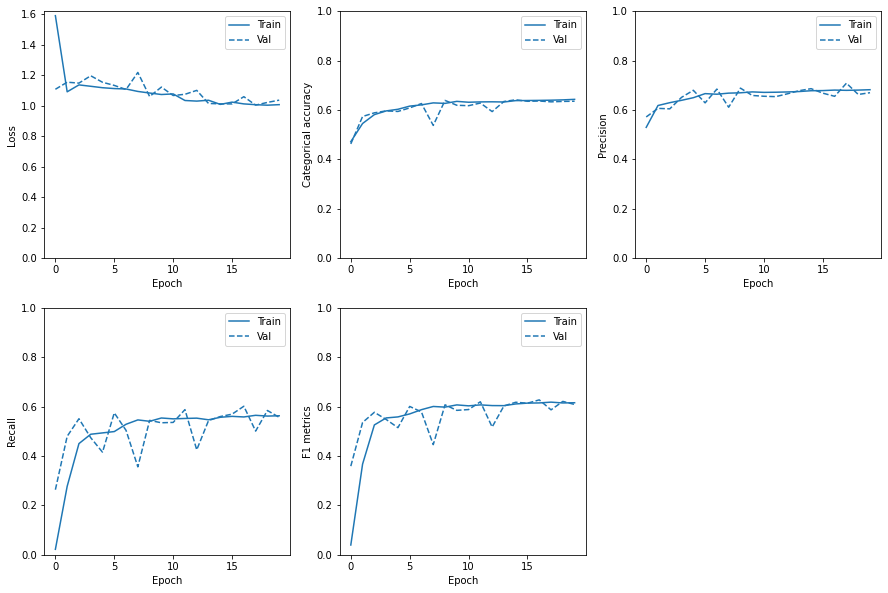

In [ ]:
cnn_4 = cnn_4(5)
train_predictions.append(cnn_4.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions.append(cnn_4.predict_classes([X_dev], batch_size=1024, verbose=2))

In [ ]:
def cnn_5(filter_size):
  model_5 = Sequential()
  model_5.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model_5.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model_5.add(Reshape((sequence_length, embedding_dim, 1)))
  model_5.add(Conv2D(1028, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model_5.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model_5.add(Flatten())
  model_5.add(Dropout(0.75))
  model_5.add(Dense(units=352, activation='relu'))
  model_5.add(Dense(units=3, activation='softmax'))
  model_5.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_model_5.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  cnn_history_5 = model_5.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, callbacks=callbacks,verbose=2, shuffle=True)
  plot_metrics(cnn_history_5)
  return model_5

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
reshape_6 (Reshape)          (None, 47, 200, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 1, 1028)       617828    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 1028)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1028)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1028)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 352)              

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 2s
8/8 - 0s


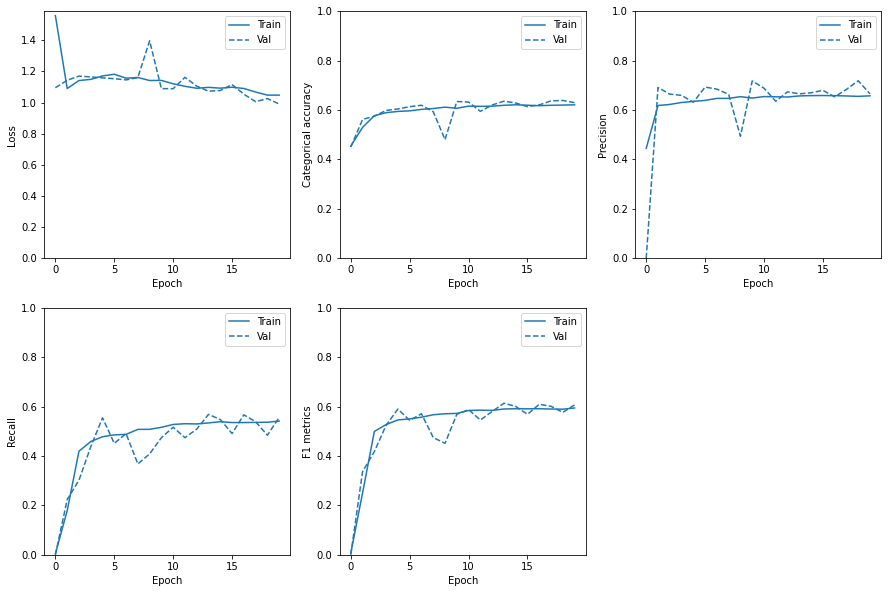

In [ ]:
cnn_5 = cnn_5(3)
train_predictions.append(cnn_5.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions.append(cnn_5.predict_classes([X_dev], batch_size=1024, verbose=2))

In [ ]:
r = np.array(list(zip(*np.squeeze(train_predictions))))
r.shape

(42257, 5)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 3125)              18750     
_________________________________________________________________
dropout_11 (Dropout)         (None, 3125)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 200)               625200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0   

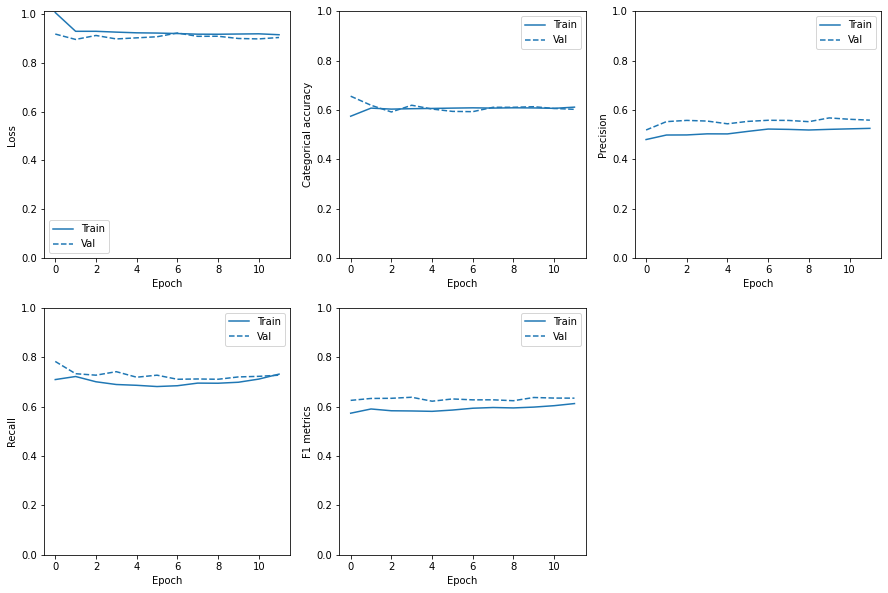

In [ ]:
from keras.layers import BatchNormalization
def stack_models(predictions, targets):
    layer_size = len(predictions)
    inp = Input(shape=(layer_size,))
    d0 = Dropout(0.2)(inp)
    d0 = Dense(pow(layer_size, 5))(d0)
    d1 = Dropout(0.2)(d0)
    d1 = Dense(40 * layer_size)(d1)
    b = BatchNormalization()(d1)
    out = Dropout(0.2)(b)
    out = Dense(3, activation='sigmoid')(out)

    cnn_models = Model(inputs=inp, outputs=out)
    cnn_models.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
    cnn_models.summary()

    x = np.array(list(zip(*np.squeeze(predictions))))
    y = targets
    print(np.shape(x))
    print(np.shape(y))
    filepath = "/content/drive/MyDrive/Colab Notebooks/stacked_cnn_models.h5"
    checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
    earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
    callbacks = [earlystop, checkpoint] 
   
    
    all_cnn_history = cnn_models.fit(x=x, y=y, epochs=100, validation_split=0.02, callbacks=callbacks,verbose=2) 
    plot_metrics(all_cnn_history)
    return cnn_models
    
stacked_cnn_model = stack_models(train_predictions, Y_train_cat)

stacked_train_predictions = np.array(list(zip(*np.squeeze(train_predictions))))
stacked_train_predictions = stacked_cnn_model.predict(stacked_train_predictions, batch_size=1024)

**STACKED LSTM PREDICTION ENSEMBLE**

In [ ]:
from keras import layers
from keras.layers import SpatialDropout1D, Bidirectional, LSTM, Dropout

In [ ]:
def lstm_1(lstm_out):
  lstm_model_1 = Sequential()
  lstm_model_1.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix] ,input_length=sequence_length))
  lstm_model_1.add(Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)))
  lstm_model_1.add(Dropout(0.2))
  lstm_model_1.add(Dense(125, activation='relu'))
  lstm_model_1.add(Dense(units=3, activation='softmax'))
  lstm_model_1.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=Metrics)
  lstm_model_1.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/lstm_1.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  history_lstm_1 = lstm_model_1.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), callbacks=callbacks,batch_size=1028, epochs=20, verbose=2)
  plot_metrics(history_lstm_1)
  scores = lstm_model_1.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (lstm_model_1.metrics_names[1], scores[1]*100))
  return lstm_model_1

In [ ]:
train_predictions_lstm = []
test_predictions_lstm = []

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               641600    
_________________________________________________________________
dropout_13 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 125)               50125     
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 378       
Total params: 9,224,103
Trainable params: 9,224,103
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
42/42 - 25s - loss: 0.9277 - categorical_accuracy: 0.5400 - precision: 0.6099 - recall: 0.3371 - f1

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 3s
8/8 - 0s


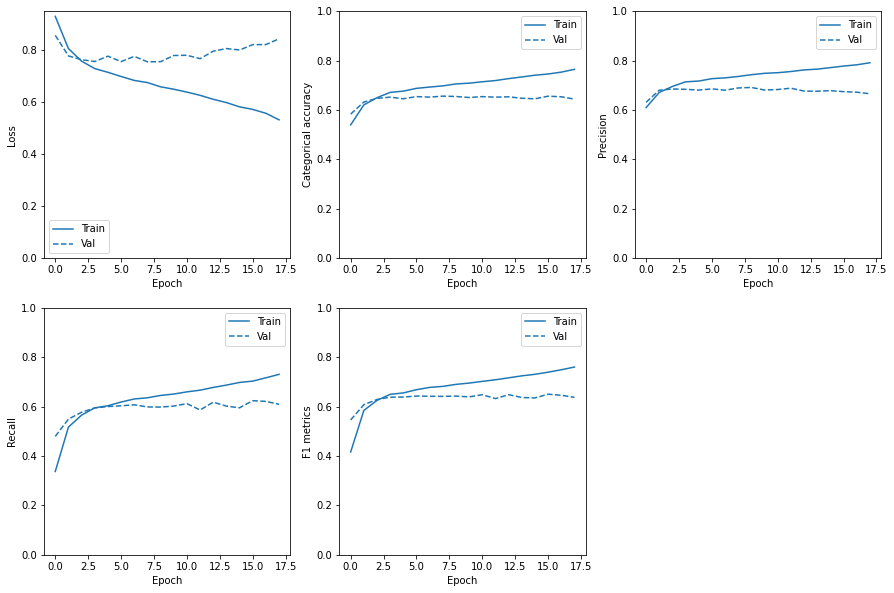

In [ ]:
lstm_1 = lstm_1(200)
train_predictions_lstm.append(lstm_1.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions_lstm.append(lstm_1.predict_classes([X_dev], batch_size=1024, verbose=2))

In [ ]:
def lstm_2(lstm_out):
  lstm_model_2 = Sequential()
  lstm_model_2.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix] ,input_length=sequence_length))
  lstm_model_2.add(Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)))
  lstm_model_2.add(Dropout(0.2))
  lstm_model_2.add(Dense(125, activation='relu'))
  lstm_model_2.add(Dense(units=3, activation='softmax'))
  lstm_model_2.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=Metrics)
  lstm_model_2.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/lstm_2.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  history_lstm_2 = lstm_model_2.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), callbacks=callbacks,batch_size=1028, epochs=20, verbose=2)
  plot_metrics(history_lstm_2)
  scores_2 = lstm_model_2.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (lstm_model_2.metrics_names[1], scores_2[1]*100))
  return lstm_model_2

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               935936    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 125)               64125     
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 378       
Total params: 9,532,439
Trainable params: 9,532,439
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
42/42 - 25s - loss: 0.9197 - categorical_accuracy: 0.5512 - precision: 0.6240 - recall: 0.3489 - f1

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 3s
8/8 - 0s


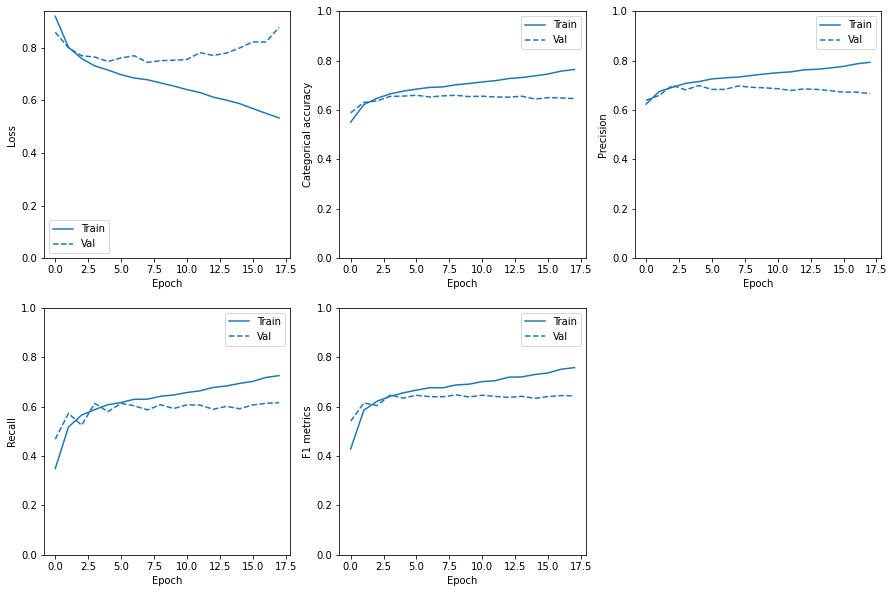

In [ ]:
lstm_2 = lstm_2(256)
train_predictions_lstm.append(lstm_2.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions_lstm.append(lstm_2.predict_classes([X_dev], batch_size=1024, verbose=2))

In [ ]:
def lstm_3(lstm_out):
  lstm_model_3 = Sequential()
  lstm_model_3.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix] ,input_length=sequence_length))
  lstm_model_3.add(Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)))
  lstm_model_3.add(Dropout(0.2))
  lstm_model_3.add(Dense(125, activation='relu'))
  lstm_model_3.add(Dense(units=3, activation='softmax'))
  lstm_model_3.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=Metrics)
  lstm_model_3.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/lstm_3.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  history_lstm_3 = lstm_model_3.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), callbacks=callbacks,batch_size=1028, epochs=20, verbose=2)
  plot_metrics(history_lstm_3)
  scores_3 = lstm_model_3.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (lstm_model_3.metrics_names[1], scores_3[1]*100))
  return lstm_model_3

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 704)               1557248   
_________________________________________________________________
dropout_15 (Dropout)         (None, 704)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 125)               88125     
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 378       
Total params: 10,177,751
Trainable params: 10,177,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
42/42 - 28s - loss: 0.9038 - categorical_accuracy: 0.5567 - precision: 0.6275 - recall: 0.3518 - 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 4s
8/8 - 1s


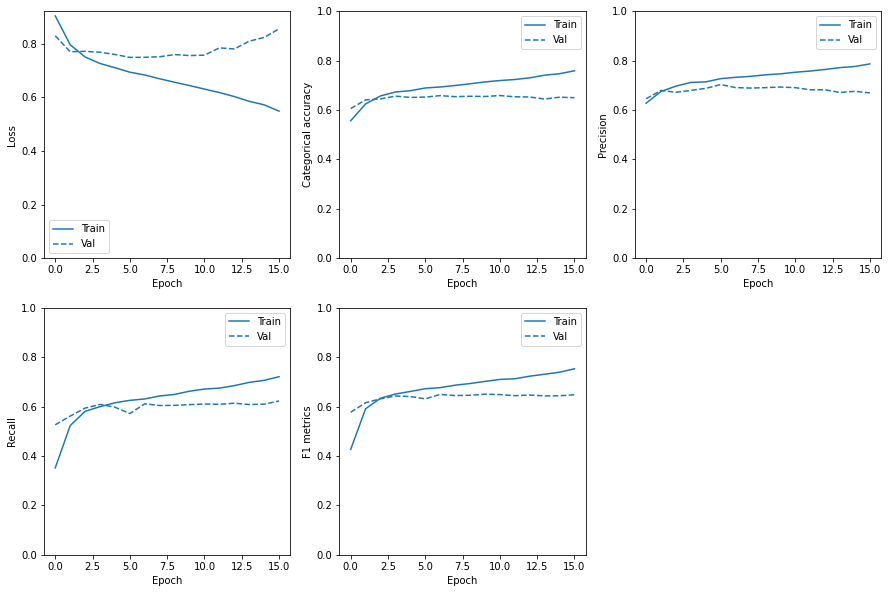

In [ ]:
lstm_3 = lstm_3(352)
train_predictions_lstm.append(lstm_3.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions_lstm.append(lstm_3.predict_classes([X_dev], batch_size=1024, verbose=2))

In [ ]:
def lstm_4(lstm_out):
  lstm_model_4 = Sequential()
  lstm_model_4.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix] ,input_length=sequence_length))
  lstm_model_4.add(Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)))
  lstm_model_4.add(Dropout(0.2))
  lstm_model_4.add(Dense(125, activation='relu'))
  lstm_model_4.add(Dense(units=3, activation='softmax'))
  lstm_model_4.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=Metrics)
  lstm_model_4.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/lstm_4.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  history_lstm_4 = lstm_model_4.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), callbacks=callbacks,batch_size=1028, epochs=20, verbose=2)
  plot_metrics(history_lstm_4)
  scores_4 = lstm_model_4.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (lstm_model_4.metrics_names[1], scores_4[1]*100))
  return lstm_model_4

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 47, 200)           8532000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 912)               2396736   
_________________________________________________________________
dropout_16 (Dropout)         (None, 912)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 125)               114125    
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 378       
Total params: 11,043,239
Trainable params: 11,043,239
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
42/42 - 30s - loss: 0.9141 - categorical_accuracy: 0.5514 - precision: 0.6206 - recall: 0.3599 -

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 5s
8/8 - 1s


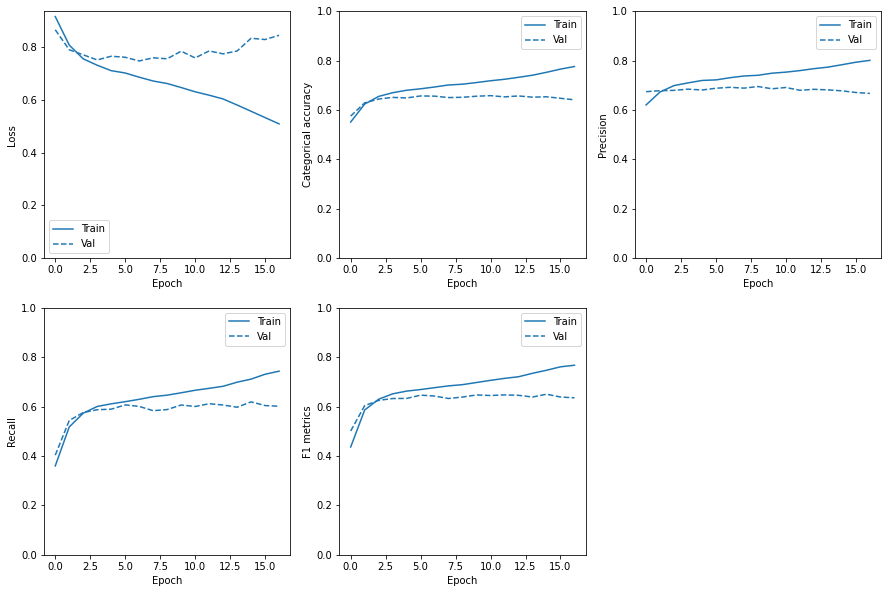

In [ ]:
lstm_4 = lstm_4(456)
train_predictions_lstm.append(lstm_4.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions_lstm.append(lstm_4.predict_classes([X_dev], batch_size=1024, verbose=2))

In [ ]:
def lstm_5(lstm_out):
  lstm_model_5 = Sequential()
  lstm_model_5.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix] ,input_length=sequence_length))
  lstm_model_5.add(Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)))
  lstm_model_5.add(Dropout(0.2))
  lstm_model_5.add(Dense(125, activation='relu'))
  lstm_model_5.add(Dense(units=3, activation='softmax'))
  lstm_model_5.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=Metrics)
  lstm_model_5.summary()

  filepath = "/content/drive/MyDrive/Colab Notebooks/lstm_5.h5"
  checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
  earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
  callbacks = [earlystop,checkpoint] 

  history_lstm_5 = lstm_model_5.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), callbacks=callbacks,batch_size=1028, epochs=20, verbose=2)
  plot_metrics(history_lstm_5)
  scores_5 = lstm_model_5.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (lstm_model_5.metrics_names[1], scores_5[1]*100))
  return lstm_model_5

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 47, 200)           8532000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1064)              3119648   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1064)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 125)               133125    
_________________________________________________________________
dense_29 (Dense)             (None, 3)                 378       
Total params: 11,785,151
Trainable params: 11,785,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
42/42 - 34s - loss: 0.9030 - categorical_accuracy: 0.5499 - precision: 0.6257 - recall: 0.3742 -

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 6s
8/8 - 1s


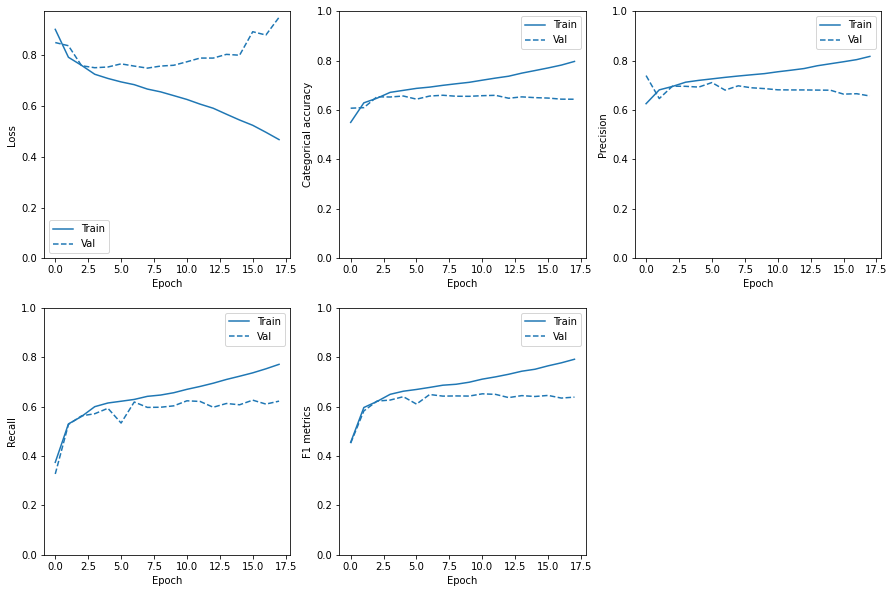

In [ ]:
lstm_5 = lstm_5(532)
train_predictions_lstm.append(lstm_5.predict_classes([X_train], batch_size=1024, verbose=2))
test_predictions_lstm.append(lstm_5.predict_classes([X_dev], batch_size=1024, verbose=2))

In [ ]:
w = np.array(list(zip(*np.squeeze(train_predictions_lstm))))
w.shape

(42257, 5)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_30 (Dense)             (None, 3125)              18750     
_________________________________________________________________
dropout_19 (Dropout)         (None, 3125)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               625200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dropout_20 (Dropout)         (None, 200)               0   

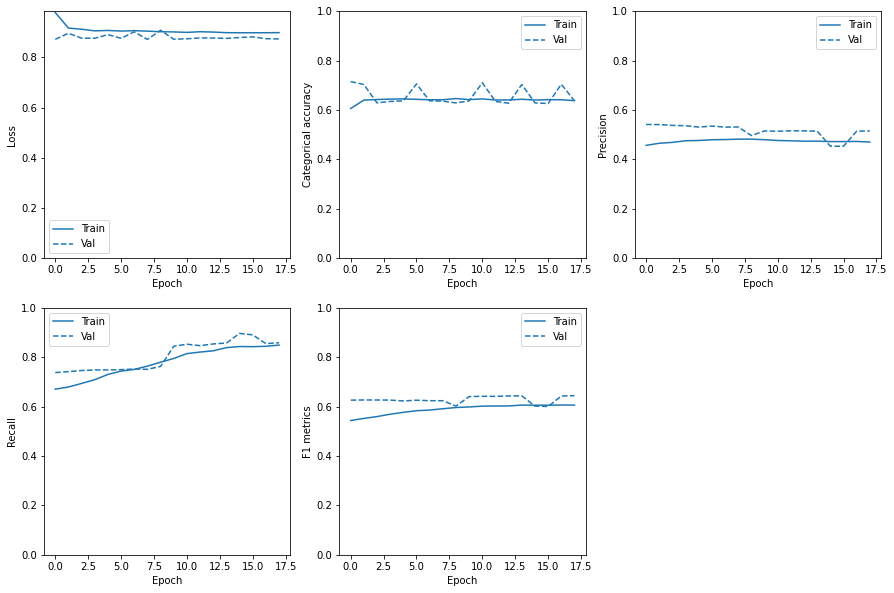

In [ ]:
from keras.layers import BatchNormalization
def lstm_stack_models(predictions, targets):
    layer_size = len(predictions)
    inp = Input(shape=(layer_size,))
    d0 = Dropout(0.2)(inp)
    d0 = Dense(pow(layer_size, 5))(d0)
    d1 = Dropout(0.2)(d0)
    d1 = Dense(40 * layer_size)(d1)
    b = BatchNormalization()(d1)
    out = Dropout(0.2)(b)
    out = Dense(3, activation='sigmoid')(out)

    all_lstm_model = Model(inputs=inp, outputs=out)
    all_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
    all_lstm_model.summary()

    x = np.array(list(zip(*np.squeeze(predictions))))
    y = targets
    print(np.shape(x))
    print(np.shape(y))
    filepath = "/content/drive/MyDrive/Colab Notebooks/stacked_lstm_models.h5"
    checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
    earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
    callbacks = [earlystop,checkpoint] 
    
    all_lstm_history = all_lstm_model.fit(x=x, y=y, epochs=50, validation_split=0.02, callbacks=callbacks,verbose=2)
    plot_metrics(all_lstm_history)
    return all_lstm_model
    
stacked_lstm_model = lstm_stack_models(train_predictions_lstm, Y_train_cat)

lstm_stacked_train_predictions = np.array(list(zip(*np.squeeze(train_predictions_lstm))))
lstm_stacked_train_predictions = stacked_lstm_model.predict(lstm_stacked_train_predictions, batch_size=1024)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 100000)            1100000   
_________________________________________________________________
dropout_25 (Dropout)         (None, 100000)            0         
_________________________________________________________________
dense_37 (Dense)             (None, 400)               40000400  
_________________________________________________________________
batch_normalization_4 (Batch (None, 400)               1600      
_________________________________________________________________
dropout_26 (Dropout)         (None, 400)               0   

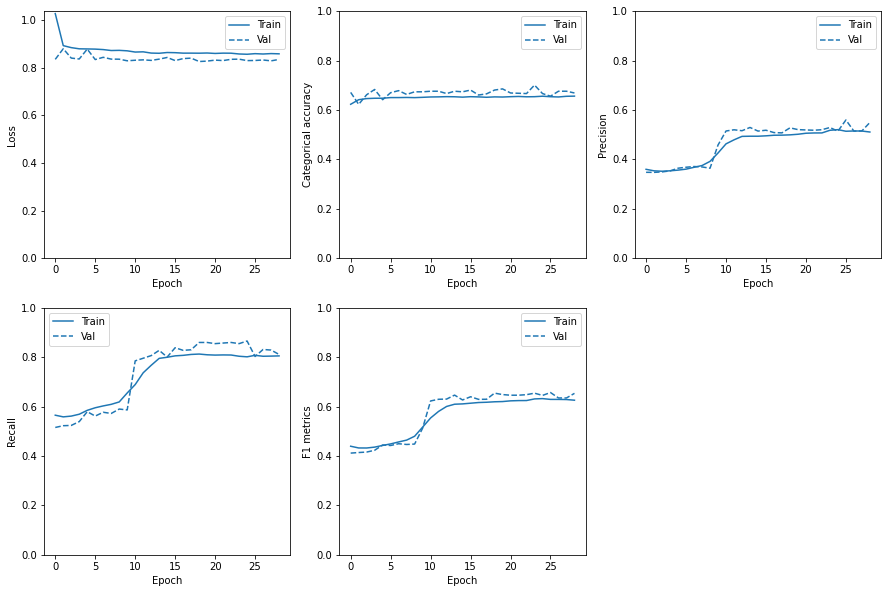

In [ ]:
total_train_predictions = train_predictions + train_predictions_lstm
total_test_predictions = test_predictions + test_predictions_lstm


def total_stack_models(predictions, targets):
    layer_size = len(predictions)
    inp = Input(shape=(layer_size,))
    d0 = Dropout(0.2)(inp)
    d0 = Dense(pow(layer_size, 5))(d0)
    d1 = Dropout(0.2)(d0)
    d1 = Dense(40 * layer_size)(d1)
    b = BatchNormalization()(d1)
    out = Dropout(0.2)(b)
    out = Dense(3, activation='sigmoid')(out)

    all_model = Model(inputs=inp, outputs=out)
    all_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
    all_model.summary()


    x = np.array(list(zip(*np.squeeze(predictions))))
    y = targets
    print(np.shape(x))
    print(np.shape(y))
    
    filepath = "/content/drive/MyDrive/Colab Notebooks/cnn_lstm_stacked.h5"
    checkpoint = ModelCheckpoint(filepath=filepath, monitor="val_f1_metrics",mode="max",save_best_only = True,verbose=2)
    earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)
    callbacks = [earlystop,checkpoint]

    total_history = all_model.fit(x=x, y=y, epochs=50, validation_split=0.02, callbacks = callbacks,verbose=2, shuffle=True)
    plot_metrics(total_history)
    return all_model
    
all_stacked_models = total_stack_models(total_train_predictions, Y_train_cat)

total_stacked_train_predictions = np.array(list(zip(*np.squeeze(total_train_predictions))))
total_stacked_train_predictions = all_stacked_models.predict(total_stacked_train_predictions, batch_size=1024)